In [1]:
from mne_bids import BIDSPath, read_raw_bids
import mne
import os
import numpy as np
from mne.preprocessing import ICA
from autoreject import AutoReject
from mne.preprocessing import ICA, create_ecg_epochs, create_eog_epochs

In [2]:
subj = '05'
BIDS_PATH = '/home/hyruuk/DATA/saflow/temp/bids/'
raw_bidspath = BIDSPath(subject=subj,
                        task="gradCPT",
                        run='02',
                        datatype="meg",
                        extension='.ds',
                        processing=None,
                        description=None,
                        root=BIDS_PATH)



In [3]:
raw = read_raw_bids(raw_bidspath, {'preload':True})
raw.set_channel_types({'ECG':'ecg',
                            'hEOG':'eog',
                            'vEOG':'eog',})# a rajouter dans raw2bids
raw = raw.apply_gradient_compensation(
    grade=3
)  # required for source reconstruction


ds directory : /home/hyruuk/DATA/saflow/temp/bids/sub-05/meg/sub-05_task-gradCPT_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.65   73.58    0.00 mm <->   -0.65   73.58    0.00 mm (orig :  -58.75   41.40 -243.83 mm) diff =    0.000 mm
       0.65  -73.58    0.00 mm <->    0.65  -73.58    0.00 mm (orig :   48.91  -58.75 -237.61 mm) diff =    0.000 mm
     102.22    0.00    0.00 mm <->  102.22   -0.00   -0.00 mm (orig :   65.43   65.41 -244.25 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /home/hyruuk/DATA/saflow/temp/bids/sub-05/meg/sub-05_task-gradCPT_run-02_meg.ds/sub-05_task-gradCPT_run-02_meg.meg4: 
    System clock channel is available, checking which samples are valid.
    1 x 588000 = 588000 samples from 334 ch

/tmp/ipykernel_28023/353065770.py:1: RuntimeWarning: The unit for channel(s) HADC001-3105, HADC002-3105, HADC003-3105, HDAC001-3105, HDAC002-3105, HDAC003-3105, HLC0011-2104, HLC0012-2104, HLC0013-2104, HLC0014-2104, HLC0015-2104, HLC0016-2104, HLC0017-2104, HLC0018-2104, HLC0021-2104, HLC0022-2104, HLC0023-2104, HLC0024-2104, HLC0025-2104, HLC0026-2104, HLC0027-2104, HLC0028-2104, HLC0031-2104, HLC0032-2104, HLC0033-2104, HLC0034-2104, HLC0035-2104, HLC0036-2104, HLC0037-2104, HLC0038-2104, SCLK01-177 has changed from V to NA.
  raw = read_raw_bids(raw_bidspath, {'preload':True})


In [5]:
picks = mne.pick_types(raw.info, meg=True, eog=True, ecg=True)

## Filtering
high_cutoff = 200
low_cutoff = 0.1
raw.filter(low_cutoff, high_cutoff, fir_design="firwin")
raw.notch_filter(
    np.arange(60, high_cutoff + 1, 60),
    picks=picks,
    filter_length="auto",
    phase="zero",
    fir_design="firwin",
)
# Create filtered copy for Autoreject and ICA fitting
raw_filt = raw.copy().filter(1, None)

## Epoching
try:
    events = mne.find_events(raw, min_duration=1 / raw.info["sfreq"], verbose=False)
except ValueError:
    events = mne.find_events(raw, min_duration=2 / raw.info["sfreq"], verbose=False)
event_id = {"Freq": 21, "Rare": 31, "Resp":99}
epochs = mne.Epochs(
    raw,
    events=events,
    event_id=event_id,
    tmin=0.426, 
    tmax=1.278,
    baseline=None,
    reject=None,
    picks=picks,
    preload=True,
)

# First, run AR on the filtered data
ar = AutoReject(n_jobs=-1)
ar.fit(epochs[:10])
autoreject_log = ar.get_reject_log(epochs)

# Update preproc file with the AR log
#raw_data.info["bads"] = autoreject_log.bad_epochs


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 39601 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 7921 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    7.8s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3961 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    5.6s


Not setting metadata
1175 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1175 events and 1024 original time points ...
0 bad epochs dropped
Removing 5 compensators from info because not all compensation channels were picked.
Running autoreject on ch_type=mag
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


  0%|          | Creating augmented epochs : 0/270 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/270 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=1


76

In [6]:
def load_noise_cov(er_date, bids_root=BIDS_PATH):
    # Noise covariance matrix
    noise_cov_bidspath = BIDSPath(subject='emptyroom', 
                    session=er_date,
                    task='noise', 
                    datatype="meg",
                    processing='noisecov',
                    root=bids_root + '/derivatives/noise_cov/')
    noise_cov_fullpath = str(noise_cov_bidspath.fpath)
    if not os.path.isfile(noise_cov_fullpath):
        er_raw = read_raw_bids(BIDSPath(subject='emptyroom', 
                    session=er_date,
                    task='noise', 
                    datatype="meg",
                    root=bids_root))
        os.makedirs(os.path.dirname(noise_cov_bidspath.fpath), exist_ok=True)
        noise_cov = mne.compute_raw_covariance(
                    er_raw, method=["shrunk", "empirical"], rank=None, verbose=True
                )
        noise_cov.save(noise_cov_fullpath)
    else:
        noise_cov = mne.read_cov(noise_cov_fullpath)
    return noise_cov

In [7]:
record_date = raw.info['meas_date'].strftime('%Y%m%d')
noise_cov = load_noise_cov(record_date)

    270 x 270 full covariance (kind = 1) found.


/tmp/ipykernel_28023/329660730.py:22: RuntimeWarning: This filename (/home/hyruuk/DATA/saflow/temp/bids/derivatives/noise_cov/sub-emptyroom/ses-20190704/meg/sub-emptyroom_ses-20190704_task-noise_proc-noisecov.fif) does not conform to MNE naming conventions. All covariance files should end with -cov.fif, -cov.fif.gz, _cov.fif or _cov.fif.gz
  noise_cov = mne.read_cov(noise_cov_fullpath)


In [33]:
# Fit ICA without autoreject
ica = ICA(n_components=20, 
            random_state=0,
            noise_cov=noise_cov).fit(raw_filt, decim=3)
ica.plot_sources(raw, show=True)

Fitting ICA to data using 270 channels (please be patient, this may take a while)
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 1.1e-11 (2.2e-16 eps * 270 dim * 1.8e+02  max singular value)
    Estimated rank (mag): 270
    MAG: rank 270 computed from 270 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 270 (0 small eigenvalues omitted)
Selecting by number: 20 components
Fitting ICA took 73.2s.
Creating RawArray with float64 data, n_channels=23, n_times=588000
    Range : 0 ... 587999 =      0.000 ...   489.999 secs
Ready.


Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 12000 samples (10.000 s)

Number of ECG events detected : 516 (average pulse 63 / min.)
Not setting metadata
516 matching events found
No baseline correction applied
Using data from preloaded Raw for 516 events and 1201 original time points ...
1 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
515 matching events found
No baseline correction applied
0 projection items activated
No component to remove


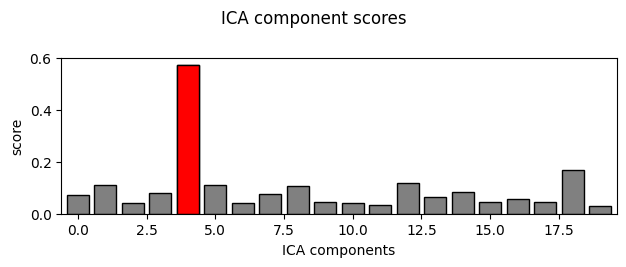

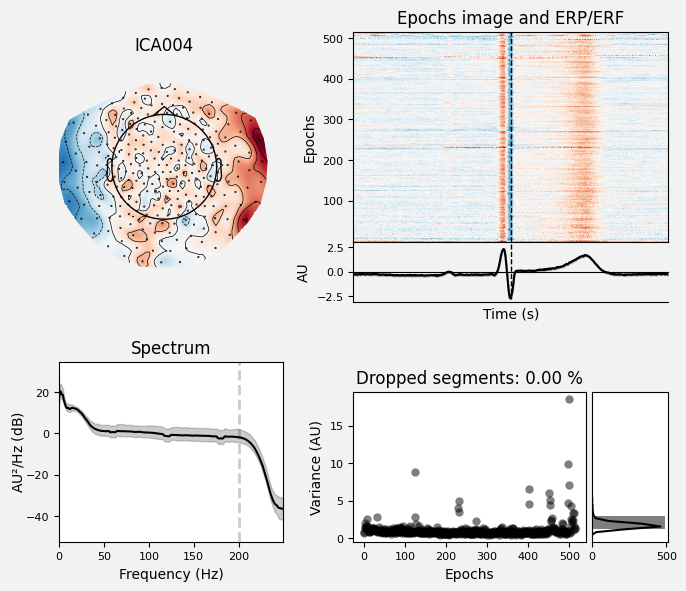

In [29]:
ecg_threshold = 0.50
ecg_epochs = create_ecg_epochs(raw, ch_name="ECG")
ecg_inds, ecg_scores = ica.find_bads_ecg(
    ecg_epochs, ch_name="ECG", method="ctps", threshold=ecg_threshold
)
fig = ica.plot_scores(ecg_scores, ecg_inds, show=False)

try:
    fig = ica.plot_properties(
        ecg_epochs, picks=ecg_inds, image_args={"sigma": 1.0}, show=False
    )
    for i, figure in enumerate(fig):
        report.add_figure(figure, title="Detected component " + str(i))
        #close(figure)
except:
    print("No component to remove")

Using EOG channel: vEOG
EOG channel index for this subject is: [301]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel vEOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 12000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 19 significant peaks
Number of EOG events detected: 19
Not setting metadata
19 matching events found
No baseline correction applied
Using data from preloaded Raw for 19 events and 1201 original time points ...
0 bad epochs dropped
Using EOG channel: vEOG
    

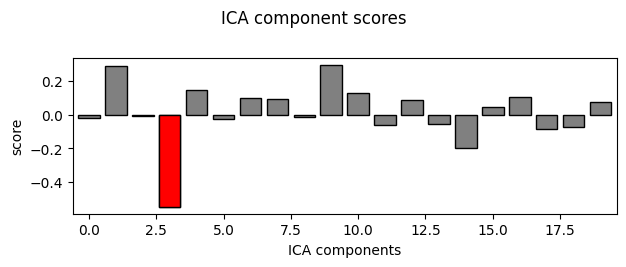

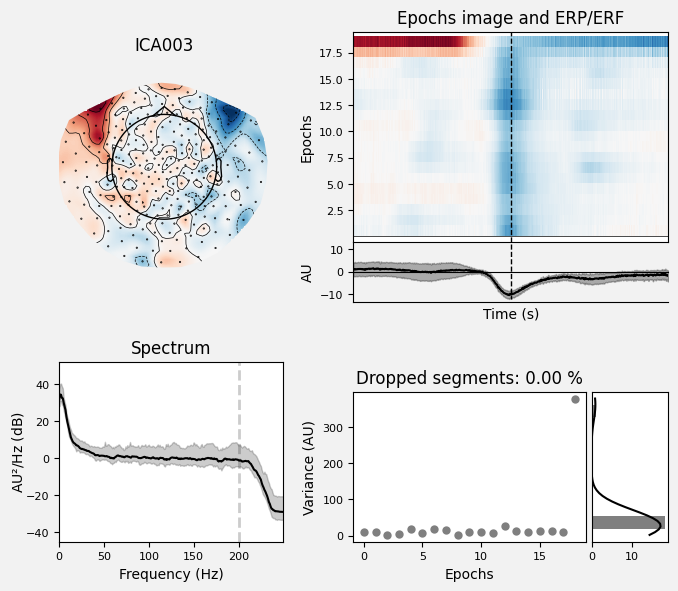

In [27]:
## FIND EOG COMPONENTS
eog_threshold = 4
eog_epochs = create_eog_epochs(raw, ch_name="vEOG")
eog_inds, eog_scores = ica.find_bads_eog(
    eog_epochs, ch_name="vEOG", threshold=eog_threshold
)
if eog_inds == []:
    eog_inds = [list(abs(eog_scores)).index(max(abs(eog_scores)))]
fig = ica.plot_scores(eog_scores, eog_inds, show=False)
#close(fig)
fig = list()
try:
    fig = ica.plot_properties(
        eog_epochs, picks=eog_inds, image_args={"sigma": 1.0}, show=False
    )
    for i, figure in enumerate(fig):
        report.add_figure(figure, title="Detected component " + str(i))
        #close(figure)
except:
    print("No component to remove")

In [35]:
ica.plot_sources(raw, show=True)

Creating RawArray with float64 data, n_channels=23, n_times=588000
    Range : 0 ... 587999 =      0.000 ...   489.999 secs
Ready.


[3]

Used Annotations descriptions: ['Freq', 'Rare', 'Resp']


(1175, 3)

NameError: name 'parser' is not defined